# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:46<00:00, 1.29KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

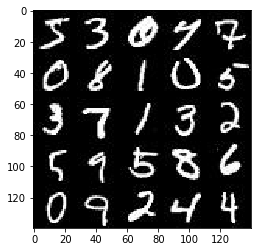

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

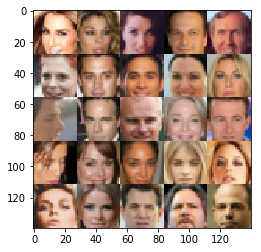

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/smaeung/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [39]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    learning_rate = tf.placeholder(tf.float32, name='lr_rate')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    inputs_real = tf.placeholder(tf.float32, [None, image_height, image_width, image_channels], name='input_real')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [40]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        #Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128,5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #7x7x256
        
        #Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [41]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        #First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        #reshape it to start the convolutoinal stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #28x28x64
        
        #output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 1, strides=1, padding='same')
        #28x28x3
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [42]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [43]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    #Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    #Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [44]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [45]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #build model
    #[batch_size, height, width, channels]
    none_data, image_height, image_width, image_channels = data_shape
    input_real, input_z, lr_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt   = model_opt(d_loss, g_loss, lr_rate, beta1)
    
    

    train_saver = tf.train.Saver()
    steps = 0
    every_100_baches = 100
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Train Model
                # scale to -1 to 1 from -0.5 to 0.5
                batch_images = batch_images * 2
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of every 10 epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, lr_rate: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images, lr_rate: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                   
                if steps % every_100_baches == 0:
                    # every 100 batches 
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3399... Generator Loss: 1.8955
Epoch 1/2... Discriminator Loss: 0.2625... Generator Loss: 2.4099
Epoch 1/2... Discriminator Loss: 2.9886... Generator Loss: 5.8143
Epoch 1/2... Discriminator Loss: 1.5268... Generator Loss: 0.6113
Epoch 1/2... Discriminator Loss: 0.8596... Generator Loss: 1.1179
Epoch 1/2... Discriminator Loss: 1.0972... Generator Loss: 0.8150
Epoch 1/2... Discriminator Loss: 1.3702... Generator Loss: 0.4579
Epoch 1/2... Discriminator Loss: 1.3170... Generator Loss: 2.6122
Epoch 1/2... Discriminator Loss: 1.0835... Generator Loss: 0.6440
Epoch 1/2... Discriminator Loss: 1.3247... Generator Loss: 0.5023


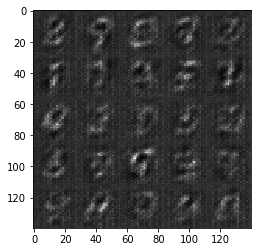

Epoch 1/2... Discriminator Loss: 0.8283... Generator Loss: 0.9557
Epoch 1/2... Discriminator Loss: 1.4864... Generator Loss: 0.3517
Epoch 1/2... Discriminator Loss: 0.8701... Generator Loss: 0.9175
Epoch 1/2... Discriminator Loss: 0.7553... Generator Loss: 1.4166
Epoch 1/2... Discriminator Loss: 0.9534... Generator Loss: 1.6798
Epoch 1/2... Discriminator Loss: 0.7459... Generator Loss: 1.4206
Epoch 1/2... Discriminator Loss: 0.7146... Generator Loss: 2.1348
Epoch 1/2... Discriminator Loss: 0.8524... Generator Loss: 1.9973
Epoch 1/2... Discriminator Loss: 0.9484... Generator Loss: 0.8229
Epoch 1/2... Discriminator Loss: 0.5530... Generator Loss: 1.7262


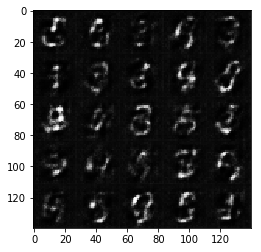

Epoch 1/2... Discriminator Loss: 0.9389... Generator Loss: 3.3636
Epoch 1/2... Discriminator Loss: 0.7062... Generator Loss: 1.2899
Epoch 1/2... Discriminator Loss: 1.4756... Generator Loss: 0.3566
Epoch 1/2... Discriminator Loss: 0.8213... Generator Loss: 0.8202
Epoch 1/2... Discriminator Loss: 0.5338... Generator Loss: 1.4134
Epoch 1/2... Discriminator Loss: 0.4478... Generator Loss: 1.9025
Epoch 1/2... Discriminator Loss: 0.5304... Generator Loss: 1.4638
Epoch 1/2... Discriminator Loss: 0.6986... Generator Loss: 0.9927
Epoch 1/2... Discriminator Loss: 1.2084... Generator Loss: 0.4324
Epoch 1/2... Discriminator Loss: 0.5114... Generator Loss: 1.7375


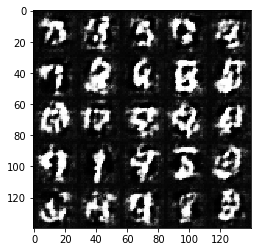

Epoch 1/2... Discriminator Loss: 0.4375... Generator Loss: 1.8568
Epoch 1/2... Discriminator Loss: 0.5100... Generator Loss: 1.5315
Epoch 1/2... Discriminator Loss: 0.4463... Generator Loss: 1.4480
Epoch 1/2... Discriminator Loss: 0.3855... Generator Loss: 1.6626
Epoch 1/2... Discriminator Loss: 0.3626... Generator Loss: 1.9683
Epoch 1/2... Discriminator Loss: 0.3953... Generator Loss: 2.2895
Epoch 1/2... Discriminator Loss: 0.4057... Generator Loss: 1.7595
Epoch 1/2... Discriminator Loss: 0.4194... Generator Loss: 1.3883
Epoch 1/2... Discriminator Loss: 0.7461... Generator Loss: 1.0563
Epoch 1/2... Discriminator Loss: 0.8173... Generator Loss: 0.9031


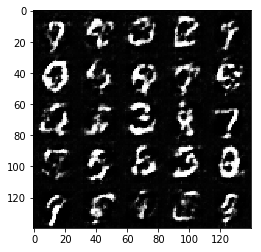

Epoch 1/2... Discriminator Loss: 0.4706... Generator Loss: 1.4122
Epoch 1/2... Discriminator Loss: 0.4320... Generator Loss: 2.5682
Epoch 1/2... Discriminator Loss: 0.4521... Generator Loss: 1.5691
Epoch 1/2... Discriminator Loss: 0.3840... Generator Loss: 1.7652
Epoch 1/2... Discriminator Loss: 0.5468... Generator Loss: 3.4397
Epoch 1/2... Discriminator Loss: 0.6692... Generator Loss: 0.9768
Epoch 1/2... Discriminator Loss: 0.5469... Generator Loss: 2.0151
Epoch 1/2... Discriminator Loss: 0.4604... Generator Loss: 1.5136
Epoch 1/2... Discriminator Loss: 0.7004... Generator Loss: 1.0040
Epoch 1/2... Discriminator Loss: 0.6432... Generator Loss: 1.2694


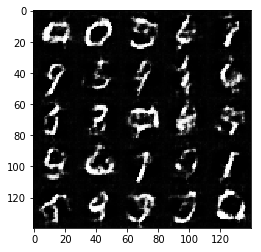

Epoch 1/2... Discriminator Loss: 1.3099... Generator Loss: 0.4480
Epoch 1/2... Discriminator Loss: 0.7318... Generator Loss: 1.0028
Epoch 1/2... Discriminator Loss: 0.5820... Generator Loss: 1.5412
Epoch 1/2... Discriminator Loss: 0.4878... Generator Loss: 1.3371
Epoch 1/2... Discriminator Loss: 0.8813... Generator Loss: 3.3565
Epoch 1/2... Discriminator Loss: 0.6794... Generator Loss: 1.3301
Epoch 1/2... Discriminator Loss: 1.0309... Generator Loss: 0.6660
Epoch 1/2... Discriminator Loss: 0.6475... Generator Loss: 1.4440
Epoch 1/2... Discriminator Loss: 0.6774... Generator Loss: 1.9844
Epoch 1/2... Discriminator Loss: 0.7004... Generator Loss: 2.0648


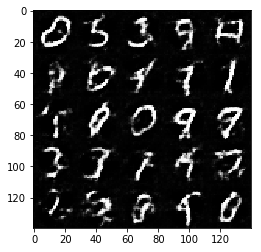

Epoch 1/2... Discriminator Loss: 0.7762... Generator Loss: 1.0539
Epoch 1/2... Discriminator Loss: 0.6249... Generator Loss: 1.4480
Epoch 1/2... Discriminator Loss: 1.3591... Generator Loss: 0.4058
Epoch 1/2... Discriminator Loss: 0.6433... Generator Loss: 1.3209
Epoch 1/2... Discriminator Loss: 0.8861... Generator Loss: 2.9152
Epoch 1/2... Discriminator Loss: 0.7709... Generator Loss: 1.0843
Epoch 1/2... Discriminator Loss: 0.7094... Generator Loss: 1.2153
Epoch 1/2... Discriminator Loss: 0.8844... Generator Loss: 1.3311
Epoch 1/2... Discriminator Loss: 0.5955... Generator Loss: 1.7116
Epoch 1/2... Discriminator Loss: 0.6402... Generator Loss: 1.2429


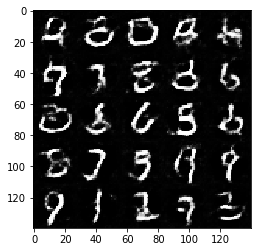

Epoch 1/2... Discriminator Loss: 0.7990... Generator Loss: 1.0230
Epoch 1/2... Discriminator Loss: 0.8791... Generator Loss: 0.8348
Epoch 1/2... Discriminator Loss: 0.6949... Generator Loss: 1.0772
Epoch 1/2... Discriminator Loss: 0.7089... Generator Loss: 0.9721
Epoch 1/2... Discriminator Loss: 0.7507... Generator Loss: 2.4837
Epoch 1/2... Discriminator Loss: 0.6150... Generator Loss: 1.2245
Epoch 1/2... Discriminator Loss: 0.8849... Generator Loss: 0.7537
Epoch 1/2... Discriminator Loss: 0.7113... Generator Loss: 1.6060
Epoch 1/2... Discriminator Loss: 0.7518... Generator Loss: 1.9349
Epoch 1/2... Discriminator Loss: 0.7892... Generator Loss: 1.0062


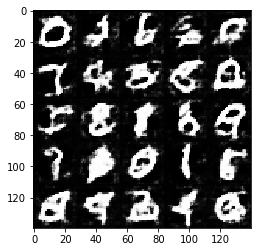

Epoch 1/2... Discriminator Loss: 0.8677... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 0.5505... Generator Loss: 1.3398
Epoch 1/2... Discriminator Loss: 0.5427... Generator Loss: 1.5968
Epoch 1/2... Discriminator Loss: 0.4313... Generator Loss: 1.6011
Epoch 1/2... Discriminator Loss: 1.0348... Generator Loss: 2.8223
Epoch 1/2... Discriminator Loss: 2.6435... Generator Loss: 0.2267
Epoch 1/2... Discriminator Loss: 0.8348... Generator Loss: 1.4133
Epoch 1/2... Discriminator Loss: 0.8080... Generator Loss: 0.8129
Epoch 1/2... Discriminator Loss: 0.5911... Generator Loss: 1.1873
Epoch 1/2... Discriminator Loss: 0.5766... Generator Loss: 1.1879


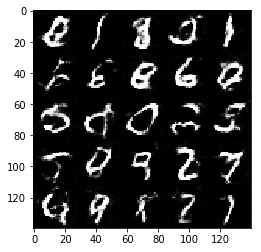

Epoch 1/2... Discriminator Loss: 1.1329... Generator Loss: 0.5124
Epoch 1/2... Discriminator Loss: 0.5833... Generator Loss: 1.1757
Epoch 1/2... Discriminator Loss: 0.6483... Generator Loss: 1.0311
Epoch 2/2... Discriminator Loss: 0.7721... Generator Loss: 0.8731
Epoch 2/2... Discriminator Loss: 0.4110... Generator Loss: 1.5396
Epoch 2/2... Discriminator Loss: 0.5193... Generator Loss: 1.3416
Epoch 2/2... Discriminator Loss: 0.7588... Generator Loss: 0.9159
Epoch 2/2... Discriminator Loss: 0.6539... Generator Loss: 1.2494
Epoch 2/2... Discriminator Loss: 0.9237... Generator Loss: 0.7457
Epoch 2/2... Discriminator Loss: 1.1866... Generator Loss: 2.9053


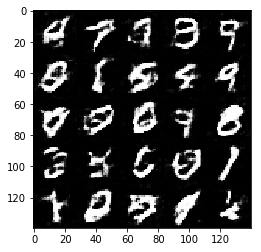

Epoch 2/2... Discriminator Loss: 0.8554... Generator Loss: 0.9728
Epoch 2/2... Discriminator Loss: 0.4389... Generator Loss: 1.7818
Epoch 2/2... Discriminator Loss: 0.5455... Generator Loss: 1.5711
Epoch 2/2... Discriminator Loss: 0.9429... Generator Loss: 0.6907
Epoch 2/2... Discriminator Loss: 0.4839... Generator Loss: 1.4857
Epoch 2/2... Discriminator Loss: 0.6758... Generator Loss: 0.9769
Epoch 2/2... Discriminator Loss: 0.7449... Generator Loss: 0.9735
Epoch 2/2... Discriminator Loss: 1.0455... Generator Loss: 0.6300
Epoch 2/2... Discriminator Loss: 0.4822... Generator Loss: 1.5338
Epoch 2/2... Discriminator Loss: 0.7002... Generator Loss: 0.9444


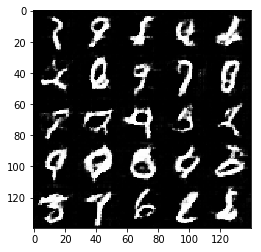

Epoch 2/2... Discriminator Loss: 0.5999... Generator Loss: 1.2201
Epoch 2/2... Discriminator Loss: 0.4630... Generator Loss: 1.3396
Epoch 2/2... Discriminator Loss: 0.3795... Generator Loss: 1.5345
Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 0.9181
Epoch 2/2... Discriminator Loss: 0.5072... Generator Loss: 1.2918
Epoch 2/2... Discriminator Loss: 0.9465... Generator Loss: 1.7595
Epoch 2/2... Discriminator Loss: 0.5904... Generator Loss: 1.4598
Epoch 2/2... Discriminator Loss: 1.2426... Generator Loss: 0.5260
Epoch 2/2... Discriminator Loss: 0.6841... Generator Loss: 1.1724
Epoch 2/2... Discriminator Loss: 0.4555... Generator Loss: 1.3468


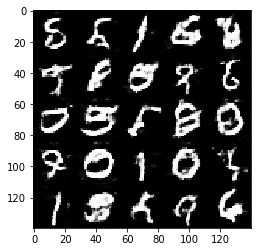

Epoch 2/2... Discriminator Loss: 0.5528... Generator Loss: 1.2817
Epoch 2/2... Discriminator Loss: 0.6737... Generator Loss: 1.0254
Epoch 2/2... Discriminator Loss: 1.0027... Generator Loss: 0.6978
Epoch 2/2... Discriminator Loss: 1.0898... Generator Loss: 0.5696
Epoch 2/2... Discriminator Loss: 6.5010... Generator Loss: 0.0068
Epoch 2/2... Discriminator Loss: 1.7886... Generator Loss: 3.5511
Epoch 2/2... Discriminator Loss: 1.0764... Generator Loss: 0.7940
Epoch 2/2... Discriminator Loss: 0.9905... Generator Loss: 0.7422
Epoch 2/2... Discriminator Loss: 0.5813... Generator Loss: 1.1566
Epoch 2/2... Discriminator Loss: 0.7143... Generator Loss: 1.0828


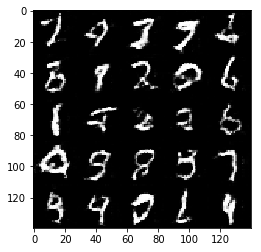

Epoch 2/2... Discriminator Loss: 0.6612... Generator Loss: 1.1580
Epoch 2/2... Discriminator Loss: 0.8264... Generator Loss: 1.8609
Epoch 2/2... Discriminator Loss: 0.7400... Generator Loss: 0.9410
Epoch 2/2... Discriminator Loss: 0.5734... Generator Loss: 2.2634
Epoch 2/2... Discriminator Loss: 2.3426... Generator Loss: 0.1864
Epoch 2/2... Discriminator Loss: 0.7432... Generator Loss: 1.2238
Epoch 2/2... Discriminator Loss: 1.0449... Generator Loss: 0.6881
Epoch 2/2... Discriminator Loss: 0.8802... Generator Loss: 0.7498
Epoch 2/2... Discriminator Loss: 0.5767... Generator Loss: 1.2274
Epoch 2/2... Discriminator Loss: 1.5636... Generator Loss: 2.9003


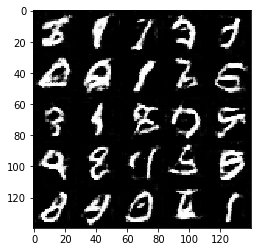

Epoch 2/2... Discriminator Loss: 2.3347... Generator Loss: 0.2474
Epoch 2/2... Discriminator Loss: 0.6980... Generator Loss: 1.5240
Epoch 2/2... Discriminator Loss: 0.7009... Generator Loss: 1.0901
Epoch 2/2... Discriminator Loss: 0.4772... Generator Loss: 1.4428
Epoch 2/2... Discriminator Loss: 0.7838... Generator Loss: 1.0376
Epoch 2/2... Discriminator Loss: 0.5902... Generator Loss: 1.5416
Epoch 2/2... Discriminator Loss: 0.9364... Generator Loss: 0.7705
Epoch 2/2... Discriminator Loss: 0.5621... Generator Loss: 1.1540
Epoch 2/2... Discriminator Loss: 0.6395... Generator Loss: 1.2236
Epoch 2/2... Discriminator Loss: 0.9093... Generator Loss: 0.8599


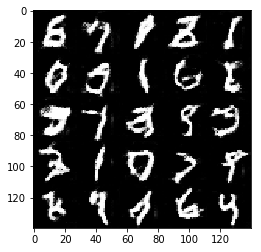

Epoch 2/2... Discriminator Loss: 0.8825... Generator Loss: 1.3788
Epoch 2/2... Discriminator Loss: 0.6050... Generator Loss: 1.1581
Epoch 2/2... Discriminator Loss: 0.3729... Generator Loss: 1.7736
Epoch 2/2... Discriminator Loss: 0.5149... Generator Loss: 1.3465
Epoch 2/2... Discriminator Loss: 0.8234... Generator Loss: 0.8960
Epoch 2/2... Discriminator Loss: 0.5043... Generator Loss: 1.7775
Epoch 2/2... Discriminator Loss: 0.8471... Generator Loss: 0.8043
Epoch 2/2... Discriminator Loss: 0.7087... Generator Loss: 0.9511
Epoch 2/2... Discriminator Loss: 0.9809... Generator Loss: 0.7085
Epoch 2/2... Discriminator Loss: 0.4325... Generator Loss: 1.5527


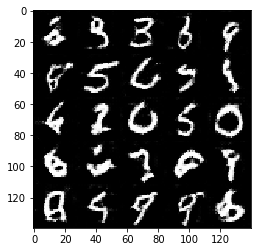

Epoch 2/2... Discriminator Loss: 0.8732... Generator Loss: 1.5288
Epoch 2/2... Discriminator Loss: 0.8555... Generator Loss: 0.8809
Epoch 2/2... Discriminator Loss: 0.9553... Generator Loss: 1.8187
Epoch 2/2... Discriminator Loss: 0.8406... Generator Loss: 1.1905
Epoch 2/2... Discriminator Loss: 0.7544... Generator Loss: 1.6020
Epoch 2/2... Discriminator Loss: 0.5245... Generator Loss: 1.5543
Epoch 2/2... Discriminator Loss: 0.6087... Generator Loss: 1.1610
Epoch 2/2... Discriminator Loss: 0.5024... Generator Loss: 1.3241
Epoch 2/2... Discriminator Loss: 0.4725... Generator Loss: 1.6170
Epoch 2/2... Discriminator Loss: 0.9620... Generator Loss: 0.7371


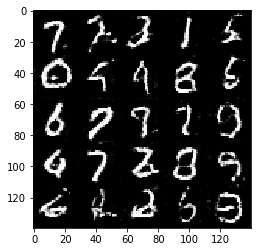

Epoch 2/2... Discriminator Loss: 0.8589... Generator Loss: 0.8287
Epoch 2/2... Discriminator Loss: 0.8044... Generator Loss: 1.6897
Epoch 2/2... Discriminator Loss: 1.2356... Generator Loss: 2.5217
Epoch 2/2... Discriminator Loss: 0.7674... Generator Loss: 0.9322
Epoch 2/2... Discriminator Loss: 0.8537... Generator Loss: 0.8261
Epoch 2/2... Discriminator Loss: 0.7586... Generator Loss: 1.0320
Epoch 2/2... Discriminator Loss: 0.8302... Generator Loss: 0.8007
Epoch 2/2... Discriminator Loss: 0.4723... Generator Loss: 1.6753
Epoch 2/2... Discriminator Loss: 0.4968... Generator Loss: 1.4312
Epoch 2/2... Discriminator Loss: 1.3987... Generator Loss: 0.7010


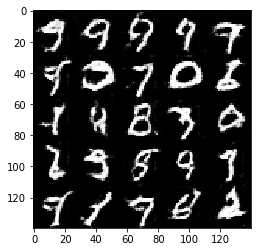

Epoch 2/2... Discriminator Loss: 0.9731... Generator Loss: 1.1816
Epoch 2/2... Discriminator Loss: 1.1049... Generator Loss: 0.8382
Epoch 2/2... Discriminator Loss: 0.7485... Generator Loss: 1.1344
Epoch 2/2... Discriminator Loss: 0.8141... Generator Loss: 2.0883
Epoch 2/2... Discriminator Loss: 0.7301... Generator Loss: 1.6768
Epoch 2/2... Discriminator Loss: 0.6740... Generator Loss: 1.3861
Epoch 2/2... Discriminator Loss: 0.5430... Generator Loss: 1.2606


In [46]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.7627... Generator Loss: 0.3512
Epoch 1/1... Discriminator Loss: 4.0686... Generator Loss: 0.2262
Epoch 1/1... Discriminator Loss: 0.7497... Generator Loss: 1.6279
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 8.3498
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 5.8215
Epoch 1/1... Discriminator Loss: 0.7161... Generator Loss: 2.7838
Epoch 1/1... Discriminator Loss: 0.2658... Generator Loss: 4.2609
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 0.4853... Generator Loss: 1.7310
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.6323


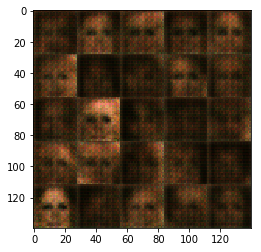

Epoch 1/1... Discriminator Loss: 0.2828... Generator Loss: 2.2853
Epoch 1/1... Discriminator Loss: 1.7214... Generator Loss: 0.2900
Epoch 1/1... Discriminator Loss: 0.8692... Generator Loss: 1.2327
Epoch 1/1... Discriminator Loss: 0.3211... Generator Loss: 2.2105
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.4049
Epoch 1/1... Discriminator Loss: 0.7926... Generator Loss: 1.1678
Epoch 1/1... Discriminator Loss: 0.6115... Generator Loss: 2.5822
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 1.4091
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 1.3311


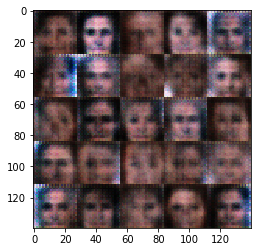

Epoch 1/1... Discriminator Loss: 2.4222... Generator Loss: 0.1472
Epoch 1/1... Discriminator Loss: 0.5494... Generator Loss: 1.9927
Epoch 1/1... Discriminator Loss: 0.3068... Generator Loss: 2.6981
Epoch 1/1... Discriminator Loss: 0.7906... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 0.5090... Generator Loss: 1.5952
Epoch 1/1... Discriminator Loss: 0.1888... Generator Loss: 5.7844
Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 1.0891
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.5130
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 0.9973... Generator Loss: 0.7151


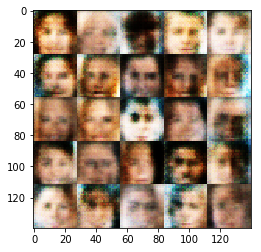

Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 6.0690
Epoch 1/1... Discriminator Loss: 0.3555... Generator Loss: 2.0650
Epoch 1/1... Discriminator Loss: 0.6361... Generator Loss: 1.1901
Epoch 1/1... Discriminator Loss: 0.3002... Generator Loss: 3.7258
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 0.4770... Generator Loss: 6.2441
Epoch 1/1... Discriminator Loss: 0.1311... Generator Loss: 3.1349
Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 3.1800
Epoch 1/1... Discriminator Loss: 0.2394... Generator Loss: 2.5625
Epoch 1/1... Discriminator Loss: 0.1826... Generator Loss: 2.8578


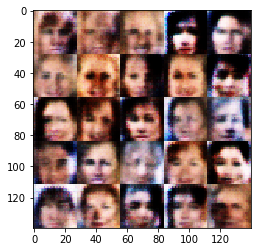

Epoch 1/1... Discriminator Loss: 0.3269... Generator Loss: 2.5163
Epoch 1/1... Discriminator Loss: 0.4246... Generator Loss: 1.6870
Epoch 1/1... Discriminator Loss: 0.0908... Generator Loss: 3.2729
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 0.0576... Generator Loss: 5.2088
Epoch 1/1... Discriminator Loss: 0.1340... Generator Loss: 4.2147
Epoch 1/1... Discriminator Loss: 0.7317... Generator Loss: 4.8341
Epoch 1/1... Discriminator Loss: 0.7151... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 0.0820... Generator Loss: 5.8038
Epoch 1/1... Discriminator Loss: 0.0524... Generator Loss: 4.7761


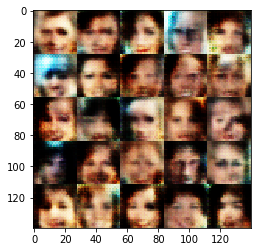

Epoch 1/1... Discriminator Loss: 0.1413... Generator Loss: 6.7182
Epoch 1/1... Discriminator Loss: 3.6125... Generator Loss: 8.8001
Epoch 1/1... Discriminator Loss: 1.6219... Generator Loss: 0.5361
Epoch 1/1... Discriminator Loss: 0.6347... Generator Loss: 1.2014
Epoch 1/1... Discriminator Loss: 0.4402... Generator Loss: 2.2644
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 0.1857... Generator Loss: 3.6352
Epoch 1/1... Discriminator Loss: 0.1587... Generator Loss: 6.2557
Epoch 1/1... Discriminator Loss: 2.3001... Generator Loss: 0.3014
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 0.9137


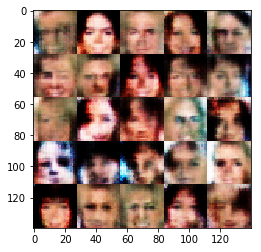

Epoch 1/1... Discriminator Loss: 0.9373... Generator Loss: 1.2309
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 0.8941... Generator Loss: 1.1587
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.5898... Generator Loss: 0.3124
Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 1.3166
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.7830


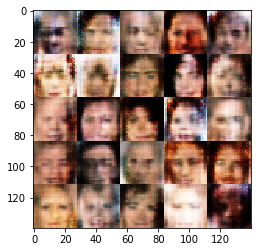

Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 1.3239
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.4364
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.7986


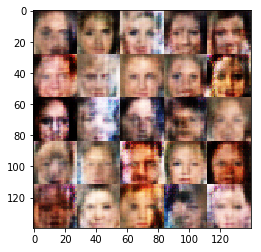

Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 1.7026
Epoch 1/1... Discriminator Loss: 1.8841... Generator Loss: 0.2267
Epoch 1/1... Discriminator Loss: 1.7146... Generator Loss: 0.4323
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 0.2413... Generator Loss: 2.1612
Epoch 1/1... Discriminator Loss: 0.1360... Generator Loss: 3.1801
Epoch 1/1... Discriminator Loss: 0.0759... Generator Loss: 3.3919
Epoch 1/1... Discriminator Loss: 0.3536... Generator Loss: 1.5710


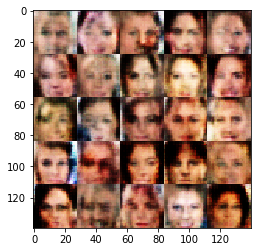

Epoch 1/1... Discriminator Loss: 0.1158... Generator Loss: 2.7439
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.4635
Epoch 1/1... Discriminator Loss: 0.0599... Generator Loss: 4.2151
Epoch 1/1... Discriminator Loss: 0.0674... Generator Loss: 6.0466
Epoch 1/1... Discriminator Loss: 0.0397... Generator Loss: 5.0151
Epoch 1/1... Discriminator Loss: 0.0546... Generator Loss: 5.8296
Epoch 1/1... Discriminator Loss: 0.0331... Generator Loss: 5.0247
Epoch 1/1... Discriminator Loss: 0.0401... Generator Loss: 4.7178
Epoch 1/1... Discriminator Loss: 0.0309... Generator Loss: 4.3481
Epoch 1/1... Discriminator Loss: 2.0514... Generator Loss: 0.7225


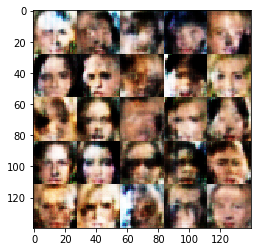

Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 2.2246
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.4841
Epoch 1/1... Discriminator Loss: 0.7887... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 1.6540... Generator Loss: 0.3250
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.2256
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 1.3835
Epoch 1/1... Discriminator Loss: 1.6149... Generator Loss: 2.2481
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.4567
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.6146


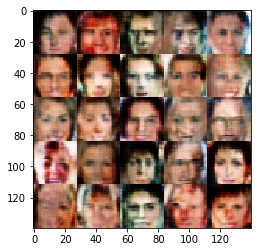

Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.5178
Epoch 1/1... Discriminator Loss: 0.9191... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.5623... Generator Loss: 0.3240
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 1.7219
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 1.6859... Generator Loss: 2.7603
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.2671


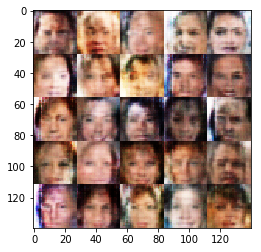

Epoch 1/1... Discriminator Loss: 1.7177... Generator Loss: 0.2918
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.4223
Epoch 1/1... Discriminator Loss: 1.7613... Generator Loss: 0.2710
Epoch 1/1... Discriminator Loss: 0.1832... Generator Loss: 3.0358
Epoch 1/1... Discriminator Loss: 2.3429... Generator Loss: 2.7034
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 1.0957
Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 1.5371
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 1.8071


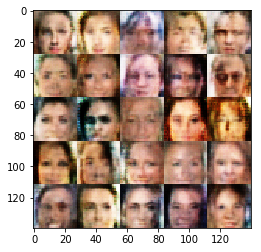

Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.5036
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 1.2851
Epoch 1/1... Discriminator Loss: 0.6606... Generator Loss: 1.4376
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.3953
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 1.4001
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 1.0451


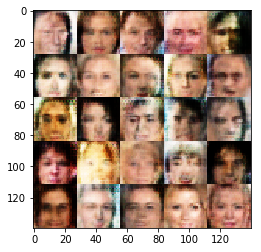

Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.5219
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.8808... Generator Loss: 0.2441
Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 0.1249... Generator Loss: 2.8288
Epoch 1/1... Discriminator Loss: 0.1406... Generator Loss: 3.9617
Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 5.1377
Epoch 1/1... Discriminator Loss: 0.1108... Generator Loss: 2.9216
Epoch 1/1... Discriminator Loss: 2.4609... Generator Loss: 4.3776
Epoch 1/1... Discriminator Loss: 1.7365... Generator Loss: 0.3244


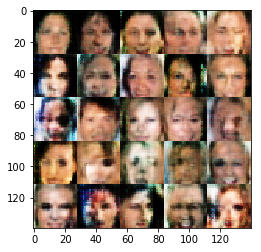

Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 2.1714
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 1.2928
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 1.4949
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 0.3517... Generator Loss: 1.8068
Epoch 1/1... Discriminator Loss: 0.8089... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 0.5184... Generator Loss: 1.2674


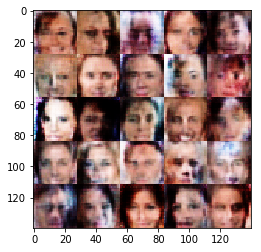

Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.3672
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 0.5867... Generator Loss: 3.3262
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 1.8367
Epoch 1/1... Discriminator Loss: 0.5499... Generator Loss: 1.0814
Epoch 1/1... Discriminator Loss: 0.1803... Generator Loss: 2.3742
Epoch 1/1... Discriminator Loss: 0.0453... Generator Loss: 4.1846
Epoch 1/1... Discriminator Loss: 0.2696... Generator Loss: 4.4723
Epoch 1/1... Discriminator Loss: 2.2110... Generator Loss: 0.1923
Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 1.2173


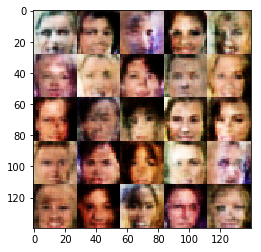

Epoch 1/1... Discriminator Loss: 0.7295... Generator Loss: 1.1965
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 2.1522
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 2.5048
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 1.2702
Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 1.4405
Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 0.6027... Generator Loss: 1.6017
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 0.6979... Generator Loss: 1.0815


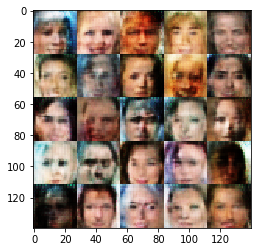

Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 1.8613
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 0.8641... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 0.1085... Generator Loss: 3.3357
Epoch 1/1... Discriminator Loss: 0.5399... Generator Loss: 2.5531
Epoch 1/1... Discriminator Loss: 0.8327... Generator Loss: 2.1490
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 1.3677
Epoch 1/1... Discriminator Loss: 0.7300... Generator Loss: 1.3520
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 2.0602


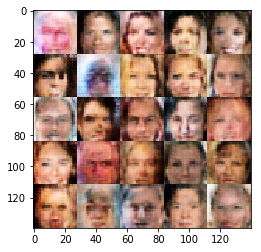

Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 1.0822
Epoch 1/1... Discriminator Loss: 2.6105... Generator Loss: 0.1309
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 0.1028... Generator Loss: 3.2580
Epoch 1/1... Discriminator Loss: 2.5167... Generator Loss: 0.1479
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 0.2400... Generator Loss: 2.7749
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 2.7572


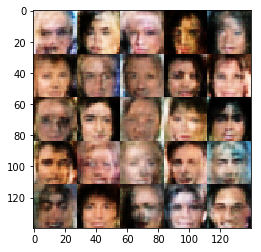

Epoch 1/1... Discriminator Loss: 0.2578... Generator Loss: 1.8640
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 5.2145
Epoch 1/1... Discriminator Loss: 0.0874... Generator Loss: 6.5200
Epoch 1/1... Discriminator Loss: 0.1665... Generator Loss: 2.3766
Epoch 1/1... Discriminator Loss: 0.3261... Generator Loss: 5.3684
Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 2.0005
Epoch 1/1... Discriminator Loss: 0.9637... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.6530... Generator Loss: 0.2891
Epoch 1/1... Discriminator Loss: 0.6557... Generator Loss: 1.0117
Epoch 1/1... Discriminator Loss: 0.8173... Generator Loss: 0.9627


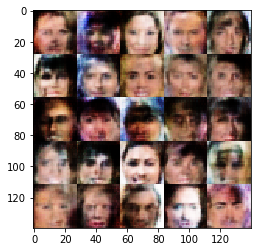

Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 1.0442
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 2.2003
Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 1.2699
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 0.7309... Generator Loss: 1.7984
Epoch 1/1... Discriminator Loss: 0.5216... Generator Loss: 1.3394
Epoch 1/1... Discriminator Loss: 2.1710... Generator Loss: 6.4058
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 1.3558


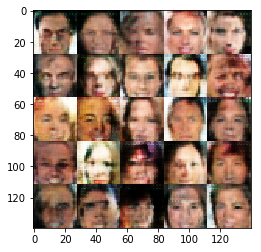

Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 0.7067... Generator Loss: 1.5803
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 2.5017
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 0.7591... Generator Loss: 1.6051
Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 3.0092


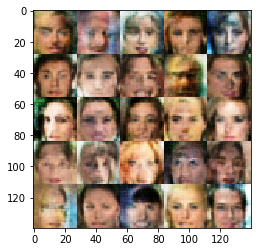

Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 0.6155... Generator Loss: 4.5031
Epoch 1/1... Discriminator Loss: 0.4504... Generator Loss: 1.5692
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.4025
Epoch 1/1... Discriminator Loss: 0.8807... Generator Loss: 2.2687
Epoch 1/1... Discriminator Loss: 0.1961... Generator Loss: 2.9986
Epoch 1/1... Discriminator Loss: 0.1599... Generator Loss: 3.0258
Epoch 1/1... Discriminator Loss: 0.0883... Generator Loss: 3.9701
Epoch 1/1... Discriminator Loss: 0.0767... Generator Loss: 5.2403
Epoch 1/1... Discriminator Loss: 0.0833... Generator Loss: 3.3121


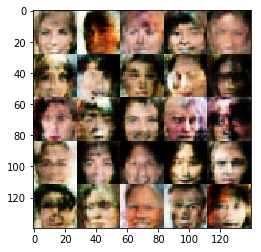

Epoch 1/1... Discriminator Loss: 0.0850... Generator Loss: 3.3022
Epoch 1/1... Discriminator Loss: 1.7983... Generator Loss: 3.4116
Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 2.7724
Epoch 1/1... Discriminator Loss: 0.8527... Generator Loss: 2.6350
Epoch 1/1... Discriminator Loss: 0.8542... Generator Loss: 2.0312
Epoch 1/1... Discriminator Loss: 0.8571... Generator Loss: 1.2455
Epoch 1/1... Discriminator Loss: 2.5710... Generator Loss: 0.1465
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 1.8979
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 1.9466
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.6075


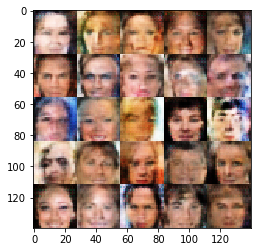

Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 0.7941... Generator Loss: 1.3941
Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 1.0823
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.4692
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 1.6750
Epoch 1/1... Discriminator Loss: 0.5869... Generator Loss: 1.6624
Epoch 1/1... Discriminator Loss: 0.7797... Generator Loss: 1.3128
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.4881
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 0.6734


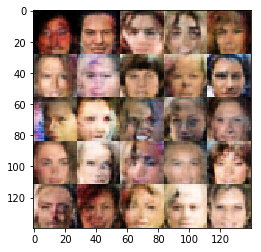

Epoch 1/1... Discriminator Loss: 0.6675... Generator Loss: 1.7506
Epoch 1/1... Discriminator Loss: 1.7060... Generator Loss: 0.3970
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 1.5719
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 1.5681
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 1.7396
Epoch 1/1... Discriminator Loss: 0.7578... Generator Loss: 2.6663
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 0.7334... Generator Loss: 1.0679
Epoch 1/1... Discriminator Loss: 1.7181... Generator Loss: 0.2754
Epoch 1/1... Discriminator Loss: 0.6383... Generator Loss: 2.1515


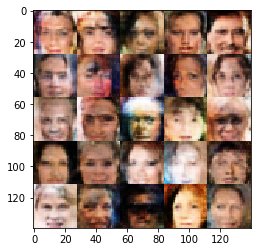

Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 1.6452
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.5673
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.3809
Epoch 1/1... Discriminator Loss: 0.6562... Generator Loss: 1.3859
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.8620
Epoch 1/1... Discriminator Loss: 2.0369... Generator Loss: 0.2411
Epoch 1/1... Discriminator Loss: 0.7876... Generator Loss: 1.1528
Epoch 1/1... Discriminator Loss: 0.4494... Generator Loss: 2.0955
Epoch 1/1... Discriminator Loss: 0.8779... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 0.7394... Generator Loss: 2.4001


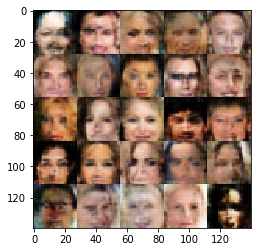

Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.4335
Epoch 1/1... Discriminator Loss: 0.7282... Generator Loss: 1.3088
Epoch 1/1... Discriminator Loss: 0.6993... Generator Loss: 1.2328
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 0.3131... Generator Loss: 2.4008
Epoch 1/1... Discriminator Loss: 0.4370... Generator Loss: 1.2977
Epoch 1/1... Discriminator Loss: 0.2562... Generator Loss: 1.9321
Epoch 1/1... Discriminator Loss: 0.0572... Generator Loss: 4.5968
Epoch 1/1... Discriminator Loss: 0.2011... Generator Loss: 2.0190
Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 1.4742


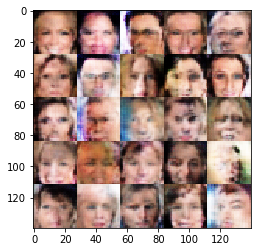

Epoch 1/1... Discriminator Loss: 0.7487... Generator Loss: 1.7510
Epoch 1/1... Discriminator Loss: 0.8831... Generator Loss: 1.7028
Epoch 1/1... Discriminator Loss: 0.7864... Generator Loss: 1.2245
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.4669
Epoch 1/1... Discriminator Loss: 0.6032... Generator Loss: 1.8763
Epoch 1/1... Discriminator Loss: 0.4229... Generator Loss: 1.5954
Epoch 1/1... Discriminator Loss: 0.2896... Generator Loss: 3.7431
Epoch 1/1... Discriminator Loss: 1.6331... Generator Loss: 0.4450
Epoch 1/1... Discriminator Loss: 0.8846... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.4419


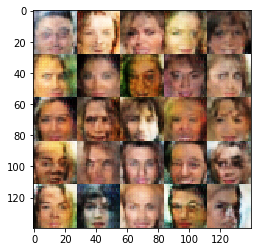

Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 1.9800
Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 0.2023... Generator Loss: 2.4453
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 2.2270
Epoch 1/1... Discriminator Loss: 0.2892... Generator Loss: 1.8948
Epoch 1/1... Discriminator Loss: 0.3724... Generator Loss: 1.6675
Epoch 1/1... Discriminator Loss: 0.5592... Generator Loss: 3.2555
Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 1.5349
Epoch 1/1... Discriminator Loss: 0.6511... Generator Loss: 1.6549
Epoch 1/1... Discriminator Loss: 0.4036... Generator Loss: 3.3975


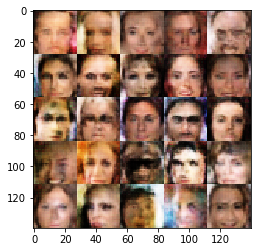

Epoch 1/1... Discriminator Loss: 0.1018... Generator Loss: 3.7313


KeyboardInterrupt: 

In [47]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.